# "Concevez une application au service de la santé publique"
_Cleaning Notebook_
13/08 16h

### Importing Modules

In [1]:
import sys
# Checking whether the notebook is on Colab or PC
is_colab = 'google.colab' in sys.modules
is_colab, sys.executable

(True, '/usr/bin/python3')

In [2]:
# Installations and importations required for Google Colab version
if is_colab==True:
  from google.colab import files, output
  !pip install python-stdnum
  !pip install gTTS
else:
    pass

In [3]:
## IMPORTATIONS

import os

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%.0f' % x)
#pd.options.display.float_format = '{:.0f}'.format

import pandas_profiling
import missingno as msno

from stdnum.exceptions import *
from stdnum.util import *
# from stdnum.util import clean, isdigits
from stdnum.ean import *

import string
from random import randint
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

import scipy.stats as st

import re
import time

%pprint # turns off pretty printing

Pretty printing has been turned OFF


In [0]:
# To play audio text-to-speech during execution
from IPython.display import Audio
from gtts import gTTS
from tempfile import TemporaryFile

def speak(my_text):
  f = TemporaryFile()
  tts = gTTS(text=my_text, lang='en')
  tts.write_to_fp(f)
  f.seek(0)
  return Audio(f.read(), autoplay=True)
  f.close()

In [5]:
speak('Packages and modules successfully imported')

### Importing dataset

In [0]:
if is_colab==False:
  # Importing database from my current local Git Repo
  df = pd.read_csv('../DATA/en.openfoodfacts.org.products.csv',
                     sep='\t', low_memory=False, encoding ='utf-8', nrows=10000)
else:
  # Importing database from the Internet
  if not os.path.exists('en.openfoodfacts.org.products.csv'):
    !wget https://static.openfoodfacts.org/data/en.openfoodfacts.org.products.csv
  else:
    pass
  df = pd.read_csv('en.openfoodfacts.org.products.csv', \
                     sep='\t', low_memory=False, encoding ='utf-8')

In [7]:
df.head(3)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_en,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_en,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,allergens,allergens_en,traces,traces_tags,traces_en,serving_size,serving_quantity,no_nutriments,additives_n,additives,additives_tags,additives_en,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,ingredients_that_may_be_from_palm_oil_tags,nutriscore_score,nutriscore_grade,nova_group,pnns_groups_1,pnns_groups_2,states,states_tags,states_en,main_category,main_category_en,image_url,image_small_url,image_ingredients_url,image_ingredients_small_url,image_nutrition_url,image_nutrition_small_url,energy-kj_100g,energy-kcal_100g,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,-butyric-acid_100g,-caproic-acid_100g,-caprylic-acid_100g,-capric-acid_100g,-lauric-acid_100g,-myristic-acid_100g,-palmitic-acid_100g,-stearic-acid_100g,-arachidic-acid_100g,-behenic-acid_100g,-lignoceric-acid_100g,-cerotic-acid_100g,-montanic-acid_100g,-melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,-alpha-linolenic-acid_100g,-eicosapentaenoic-acid_100g,-docosahexaenoic-acid_100g,omega-6-fat_100g,-linoleic-acid_100g,-arachidonic-acid_100g,-gamma-linolenic-acid_100g,-dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,-oleic-acid_100g,-elaidic-acid_100g,-gondoic-acid_100g,-mead-acid_100g,-erucic-acid_100g,-nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,-sucrose_100g,-glucose_100g,-fructose_100g,-lactose_100g,-maltose_100g,-maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-dried_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,0000000000017,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1529059080,2018-06-15T10:38:00Z,1561463718,2019-06-25T11:55:18Z,Vitória crackers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,France,en:france,France,NaN,NaN,nan,NaN,NaN,NaN,NaN,nan,nan,nan,NaN,NaN,NaN,nan,nan,NaN,nan,nan,NaN,nan,NaN,nan,unknown,unknown,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr...",NaN,NaN,https://static.openfoodfacts.org/images/produc...,https://static.openfoodfacts.org/images/produc...,https://static.openfoodfacts.org/images/produc...,https://static.openfoodfacts.org/images/produc...,NaN,NaN,nan,1569,1569,nan,7,3,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,70,15,nan,nan,nan,nan,nan,nan,nan,nan,nan,8,nan,nan,nan,1,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na

In [8]:
speak('Dataset successfully imported')

## Data preprocessing

### Description

In [9]:
# Shape of the dataset
dfshape = df.shape # (1173417, 178) (954463, 175)
dfshape

(1173417, 178)

In [0]:
# General description 
desc_df = df.describe(include='all')
# Types and content of the columns
desc_type = pd.DataFrame(df.dtypes, columns=['type']).T
# Null stats per column
nb_null = (dfshape[0]-desc_df.loc["count"].T)
pct_null = (dfshape[0]-desc_df.loc["count"].T)*100/dfshape[0]
desc_null = pd.DataFrame([nb_null, pct_null], index=['nb null','pct null'])
# Concatenate general, type and null stats
my_desc = pd.concat([desc_type, desc_null, desc_df])

In [11]:
my_desc

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_en,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_en,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,allergens,allergens_en,traces,traces_tags,traces_en,serving_size,serving_quantity,no_nutriments,additives_n,additives,additives_tags,additives_en,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,ingredients_that_may_be_from_palm_oil_tags,nutriscore_score,nutriscore_grade,nova_group,pnns_groups_1,pnns_groups_2,states,states_tags,states_en,main_category,main_category_en,image_url,image_small_url,image_ingredients_url,image_ingredients_small_url,image_nutrition_url,image_nutrition_small_url,energy-kj_100g,energy-kcal_100g,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,-butyric-acid_100g,-caproic-acid_100g,-caprylic-acid_100g,-capric-acid_100g,-lauric-acid_100g,-myristic-acid_100g,-palmitic-acid_100g,-stearic-acid_100g,-arachidic-acid_100g,-behenic-acid_100g,-lignoceric-acid_100g,-cerotic-acid_100g,-montanic-acid_100g,-melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,-alpha-linolenic-acid_100g,-eicosapentaenoic-acid_100g,-docosahexaenoic-acid_100g,omega-6-fat_100g,-linoleic-acid_100g,-arachidonic-acid_100g,-gamma-linolenic-acid_100g,-dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,-oleic-acid_100g,-elaidic-acid_100g,-gondoic-acid_100g,-mead-acid_100g,-erucic-acid_100g,-nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,-sucrose_100g,-glucose_100g,-fructose_100g,-lactose_100g,-maltose_100g,-maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-dried_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
type,object,object,object,int64,object,int64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,float64,object,object,object,object,object,object,object,object,float64,object,object,object,object,float64,float64,float64,object,object,object,float64,float64,object,float64,float64,object,float64,object,float64,object,object,object,object,object,object,object,object,object,object,object,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float6

14 columns with no entry, no row has all the columns filled.

In [12]:
speak('Description overview done')

### Memory usage reduction

In order to facilitate the manipulation, we can specify the format of each column while loading the data in a pandas dataframe.
The precision of float16 is only 3 digit vs. 15 for float64. 

In [13]:
# # Checking the memory usage
df.info() #(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1173417 entries, 0 to 1173416
Columns: 178 entries, code to carnitine_100g
dtypes: float64(120), int64(2), object(56)
memory usage: 1.6+ GB


In [0]:
## Changing format of object and float64 columns
my_dtypes = {}
# object -> category (if nb unique < 10000)
for col in df.columns.values:
    if df[col].dtype == 'object' and  len(df[col].unique()) < 10000 :
        my_dtypes[col] = 'category'
# float64 -> float16
for col in df.columns.values:
    if df[col].dtype == 'float64':
        my_dtypes[col] = 'float16'

In [0]:
# Reload data with changed types
if is_colab==False:
  # Importing database from my current local Git Repo
  df = pd.read_csv('../DATA/en.openfoodfacts.org.products.csv', dtype=my_dtypes,
                     sep='\t', low_memory=False, encoding ='utf-8', nrows=10000)
else:
  # Importing database from the Internet (if not already in \content\)
  if not os.path.exists('en.openfoodfacts.org.products.csv'):
    !wget https://static.openfoodfacts.org/data/en.openfoodfacts.org.products.csv
  else:
    pass
  df = pd.read_csv('en.openfoodfacts.org.products.csv', dtype=my_dtypes,\
                     sep='\t', low_memory=False, encoding ='utf-8')

In [16]:
# Re-check memory usage
df.info(memory_usage='deep') # 'deep': enables more accurate memory usage report

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1173417 entries, 0 to 1173416
Columns: 178 entries, code to carnitine_100g
dtypes: category(19), float16(120), int64(2), object(37)
memory usage: 2.9 GB


In [17]:
speak("Data reloaded with reduction of memory usage")

Main conclusions : 
- Description :
  954463 rows and 175 columns
  some of them categorical, 
  some of them numerical
- Memory usage reduction : 
  4.6 GB -> 2.2 GB

### Pandas Data Profiling report

In [0]:
dfcopy = df.copy(deep = True)

In [0]:
# Generating a Data Profiling html report via pandas_profiling
# profile = pandas_profiling.ProfileReport(dfcopy) #, check_correlation = False
# profile.to_file("OFFacts_report2_3.html")
# profile

In [0]:
# # extract rejected columns (based on correlation coeff greater than 0.9)
# rejected_variables_90 = profile.get_rejected_variables(threshold=0.9)
# len(rejected_variables_90)

In [0]:
# speak('Pandas profiling report generated')

Main conclusions : 

### Filtering out unimportant columns
#### 1. Non relevant columns
Some columns can immediately be classied as non useful for our project and can be dropped : 
- 5 columns concerning to the image of the product: 'image_small_url',	'image_ingredients_url',	'image_ingredients_small_url',	'image_nutrition_url'	'image_nutrition_small_url'
- 3 columns concerning the level of completion of the row: 'states', 'states_tags', 'states_en' 


In [22]:
li_col_del = ['image_url', 'image_small_url',	'image_ingredients_url',
              'image_ingredients_small_url',	'image_nutrition_url',
              'image_nutrition_small_url',
              'states', 'states_tags', 'states_en' ]
# Filtering out 8 non relevant columns
dfcopy.drop(columns=li_col_del, inplace=True)
dfcopy.shape

(1173417, 169)

#### 2. Almost empty columns

In [23]:
# Checking all 'null' columns
nbnotnulldf = pd.DataFrame((~dfcopy.isna()).sum(axis =0),
                           columns=['nb'])
nbnotnulldf.sort_values(by=['nb'], axis=0, ascending=True, inplace=True)
nbnotnulldf.T.head(150)

,ingredients_that_may_be_from_palm_oil,-nervonic-acid_100g,allergens_en,-gondoic-acid_100g,-elaidic-acid_100g,ingredients_from_palm_oil,-erucic-acid_100g,no_nutriments,-mead-acid_100g,-lignoceric-acid_100g,water-hardness_100g,-caproic-acid_100g,-melissic-acid_100g,cities,-caprylic-acid_100g,-myristic-acid_100g,-behenic-acid_100g,-stearic-acid_100g,-butyric-acid_100g,-dihomo-gamma-linolenic-acid_100g,chlorophyl_100g,-montanic-acid_100g,-cerotic-acid_100g,-palmitic-acid_100g,glycemic-index_100g,-arachidic-acid_100g,-capric-acid_100g,-gamma-linolenic-acid_100g,phylloquinone_100g,-lauric-acid_100g,-maltose_100g,nucleotides_100g,-maltodextrins_100g,-arachidonic-acid_100g,carnitine_100g,-oleic-acid_100g,beta-glucan_100g,serum-proteins_100g,additives,choline_100g,inositol_100g,casein_100g,omega-9-fat_100g,nutrition-score-uk_100g,-glucose_100g,chromium_100g,molybdenum_100g,beta-carotene_100g,-fructose_100g,silica_100g,-eicosapentaenoic-acid_100g,taurine_100g,-sucrose_100g,-docosahexaenoic-acid_100g,ph_100g,-linoleic-acid_100g,fluoride_100g,caffeine_100g,collagen-meat-protein-ratio_100g,fruits-vegetables-nuts-dried_100g,-alpha-linolenic-acid_100g,bicarbonate_100g,omega-6-fat_100g,starch_100g,carbon-footprint_100g,-lactose_100g,chloride_100g,biotin_100g,iodine_100g,polyols_100g,energy-from-fat_100g,vitamin-k_100g,selenium_100g,omega-3-fat_100g,manganese_100g,copper_100g,vitamin-e_100g,folates_100g,pantothenic-acid_100g,zinc_100g,cocoa_100g,fruits-vegetables-nuts_100g,vitamin-b9_100g,vitamin-b12_100g,phosphorus_100g,magnesium_100g,vitamin-b6_100g,vitamin-d_100g,carbon-footprint-from-meat-or-fish_100g,fruits-vegetables-nuts-estimate_100g,vitamin-b2_100g,ingredients_from_palm_oil_tags,vitamin-b1_100g,vitamin-pp_100g,alcohol_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,potassium_100g,ingredients_that_may_be_from_palm_oil_tags,first_packaging_code_geo,cities_tags,origins_tags,origins,traces,emb_codes_tags,emb_codes,traces_en,traces_tags,allergens,manufacturing_places_tags,manufacturing_places,energy-kj_100g,generic_name,purchase_places,vitamin-a_100g,vitamin-c_100g,iron_100g,trans-fat_100g,cholesterol_100g,calcium_100g,stores,packaging_tags,packaging,additives_en,additives_tags,serving_size,serving_quantity,labels,labels_tags,labels_en,fiber_100g,nutriscore_grade,nutriscore_score,nutrition-score-fr_100g,nova_group,quantity,main_category_en,categories_tags,categories_en,main_category,categories,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,additives_n,ingredients_text,brands_tags,brands,energy-kcal_100g,saturated-fat_100g,sugars_100g,sodium_100g,salt_100g,carbohydrates_100g,fat_100g,proteins_100g,energy_100g,product_name,pnns_groups_1,countries_tags,countries_en,countries,pnns_groups_2,creator,created_datetime,last_modified_datetime,last_modified_t,created_t,url,code
nb,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,2,2,3,3,3,3,4,5,7,9,9,13,16,16,17,21,22,36,37,37,39,40,43,52,53,66,69,71,73,102,102,112,120,138,149,200,266,278,289,291,310,319,391,397,410,508,581,630,652,845,960,1038,1357,1660,1898,2318,2721,3094,3135,4656,4927,6015,6192,6536,6839,8010,8119,8699,9912,10745,12016,12470,12552,12825,14173,24620,24676,26528,27290,46635,50103,57683,57783,70203,72871,72900,89431,89431,90746,91692,91730,94107,97459,129551,139321,143026,143162,144479,145324,146946,192245,202823,202832,256605,256605,288252,288376,289372,289393,289393,311740,331253,331253,331262,346683,361850,434257,434257,434257,434257,434258,471753,471753,471753,471860,720900,720949,855630,892306,908296,913234,913278,922774,922852,924333,929759,1117597,1161237,1171423,1171423,1171425,1173213,1173413,1173416,1173417,1173417,1173417,1173417,1173417


In [24]:
# Displaying a table with bins
mask = pd.cut(nbnotnulldf['nb'], [-1,0,5,10,100,300,1000000]) # 
mask.value_counts(normalize=False, sort=False)

(-1, 0]           14
(0, 5]            14
(5, 10]            3
(10, 100]         18
(100, 300]        11
(300, 1000000]    96
Name: nb, dtype: int64

<BarContainer object of 43 artists>

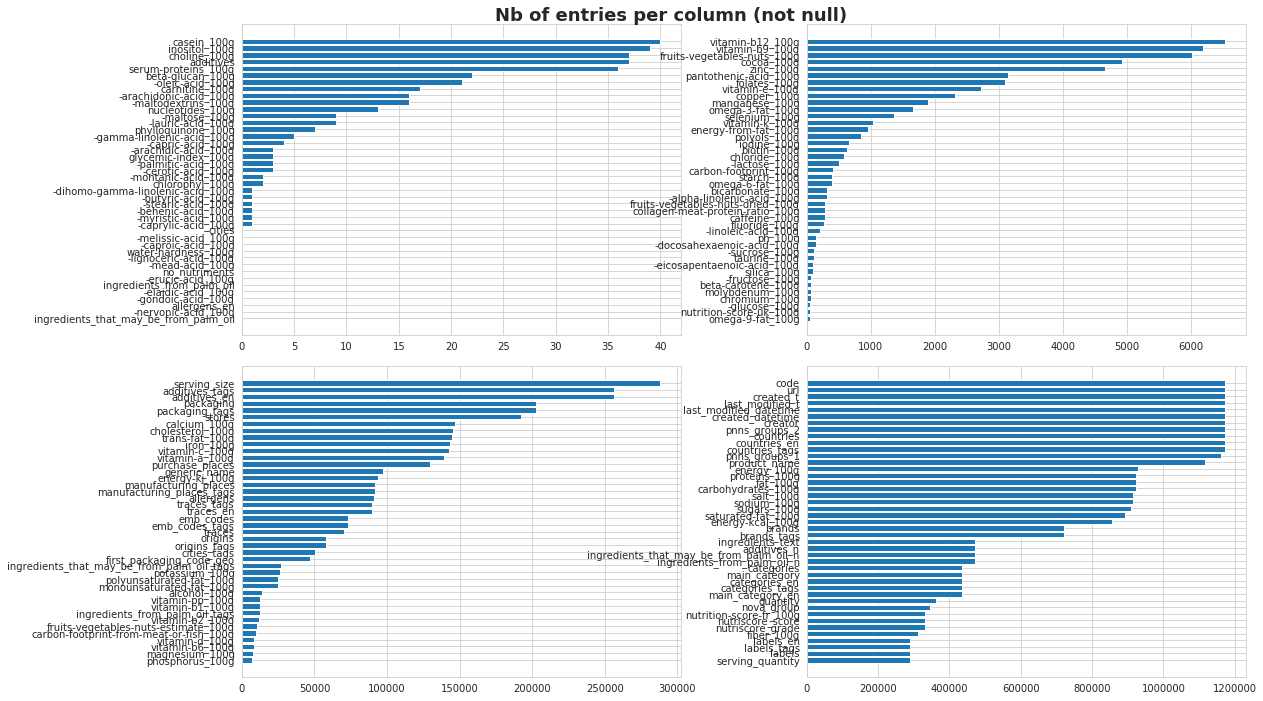

In [25]:
# Plotting barplots of nb of not null per column
fig = plt.figure(figsize = (18, 12))
grid = plt.GridSpec(2, 4, wspace=0.8, hspace=0.1)
np.warnings.filterwarnings('ignore')

fig.suptitle("Nb of entries per column (not null)",
             x=0.32, y=0.9, ha='left', va='top', fontsize=18, fontweight = 'bold')

ax1 = plt.subplot(grid[0, 0:2])
ax1.barh(nbnotnulldf['nb'].index.to_list()[:42] , width=nbnotnulldf['nb'].values[:42])
ax2 = plt.subplot(grid[0, 2:4])
ax2.barh(nbnotnulldf['nb'].index.to_list()[42:84] , width=nbnotnulldf['nb'].values[42:84])
ax3 = plt.subplot(grid[1, 0:2])
ax3.barh(nbnotnulldf['nb'].index.to_list()[84:126] , width=nbnotnulldf['nb'].values[84:126])
ax4 = plt.subplot(grid[1, 2:4])
ax4.barh(nbnotnulldf['nb'].index.to_list()[126:170] , width=nbnotnulldf['nb'].values[126:170])


In [26]:
# Displaying names of columns with less than 300 entries (0.031%)
mask=pd.cut(nbnotnulldf['nb'], [-1,300])
li_col_del = mask[~mask.values.isna()].index
len(li_col_del), li_col_del

(60, Index(['ingredients_that_may_be_from_palm_oil', '-nervonic-acid_100g', 'allergens_en', '-gondoic-acid_100g', '-elaidic-acid_100g', 'ingredients_from_palm_oil', '-erucic-acid_100g', 'no_nutriments', '-mead-acid_100g', '-lignoceric-acid_100g', 'water-hardness_100g', '-caproic-acid_100g', '-melissic-acid_100g', 'cities', '-caprylic-acid_100g', '-myristic-acid_100g', '-behenic-acid_100g', '-stearic-acid_100g', '-butyric-acid_100g', '-dihomo-gamma-linolenic-acid_100g', 'chlorophyl_100g', '-montanic-acid_100g', '-cerotic-acid_100g', '-palmitic-acid_100g', 'glycemic-index_100g', '-arachidic-acid_100g', '-capric-acid_100g', '-gamma-linolenic-acid_100g', 'phylloquinone_100g', '-lauric-acid_100g', '-maltose_100g', 'nucleotides_100g', '-maltodextrins_100g', '-arachidonic-acid_100g', 'carnitine_100g', '-oleic-acid_100g', 'beta-glucan_100g', 'serum-proteins_100g', 'additives', 'choline_100g', 'inositol_100g', 'casein_100g', 'omega-9-fat_100g', 'nutrition-score-uk_100g', '-glucose_100g',
      

61 columns contain less than 300 entries.
Some of them (11) might nevertheless be used to complete other columns with similar content and require more investigation, or could be used on small specialized subsets of data (mineral waters, energizing drinks, meats...). They should not be dropped at first :
- 'additives',
- 'chromium_100g',
- 'molybdenum_100g',
- 'taurine_100g'
- 'silica_100g',
- 'ph_100g',
- 'caffeine_100g',
- 'fluoride_100g',
- 'bicarbonate_100g',
- 'fruits-vegetables-nuts-dried_100g',
- 'collagen-meat-protein-ratio_100g'

In [27]:
# Removing 11 columns from the "to-be-deleted" columns list 
li_col_not_del =  ['additives', 'chromium_100g', 'molybdenum_100g', 
                   'taurine_100g', 'silica_100g', 'ph_100g', 'caffeine_100g', 
                   'fluoride_100g', 'bicarbonate_100g',
                   'fruits-vegetables-nuts-dried_100g', 
                   'collagen-meat-protein-ratio_100g']
li_col_del = [i for i in li_col_del if i not in li_col_not_del]
# Filtering out 50 columns with less than 300 entries (0.021%)
dfcopy.drop(columns=li_col_del, inplace=True)
dfcopy.shape

(1173417, 119)

#### 3. Columns with redundant information

Some of the columns seem to contain similar information. For example : 
  - 'created_t' vs.	'created_datetime'
  - 'last_modified_t' vs.	'last_modified_datetime'
  - 'brands' vs.	'brands_tags'
  - 'categories	' vs.	'categories_tags'  vs.	'categories_en'  
  - 'origins' vs.	'origins_tags'
  - 'manufacturing_places' vs.	'manufacturing_places_tags'
  - 'labels' vs.	'labels_tags'  vs.	'labels_en' 
  - 'emb_codes' vs.	'emb_codes_tags'
  - 'countries' vs.	'countries_tags'  vs.	'countries_en'
  - 'traces' vs.	'traces_tags'  vs.	'traces_en'
  - 'additives_n' vs. 'additives' vs.	'additives_tags'  vs.	'additives_en'


Let's see if some of them can be dropped or their content gathered in only one column.
To that end, we define a function '**comp_df**' that :
- compares the content of two columns col1 and col2 of the dataframe
- prints the number or rows with 1) both columns, 2) col1 only, 3) col2 only, and 4) none of them filled
- returns indexes of 1) data in both columns, 2) data only in col1, 3) data only in col2, and 4) no data at all.

After that, we check and compare the content of the columns when both are filled in order to get familiar with the content of the database.

In [0]:
def comp_df (df, col1, col2):
  mboth = (~df[[col1,col2]].isna()).sum(axis=1)==2 # mask for both cells filled
  mone = (~df[[col1,col2]].isna()).sum(axis=1)==1 # mask for only one cell filled
  mcol1 = mone & ~df[col1].isna() # mask for only col1 cell filled
  mcol2 = mone & ~df[col2].isna() # mask for only col2 cell filled
  mnone = ~mone & ~mboth
  ind_both = df.index[mboth].to_list()
  ind_col1 = df.index[mcol1].to_list()
  ind_col2 = df.index[mcol2].to_list()
  ind_none = df.index[mnone].to_list()
  #ind_none = df.index[mnone].tolist()
  print("nb rows both filled: ", len(ind_both))
  print("nb rows with only", col1, "filled: ", len(ind_col1))
  print("nb rows with only", col2, "filled: ", len(ind_col2))
  print("nb rows not filled: ", len(ind_none))
  return(ind_both, ind_col1, ind_col2, ind_none)

Here is an example of the code we have used to address 'brands' and 'brands_tags' columns:

In [29]:
# Compares content of 2 columns, print info and returns indexes 
c1 = 'brands'
c2 = c1+'_tags'
t_ind = comp_df(dfcopy, c1, c2)
dfcopy.loc[(t_ind[1]+t_ind[2])[53:57],[c1, c2]]

nb rows both filled:  720892
nb rows with only brands filled:  57
nb rows with only brands_tags filled:  8
nb rows not filled:  452460


,brands,brands_tags
1124207,.,NaN
1136044,-,NaN
1143168,?,NaN
1162340,???,NaN


In [30]:
# Displaying cells when both columns are filled
dfcopy.loc[t_ind[0], [c1,c2]].head(4)

,brands,brands_tags
3,courte paille,courte-paille
4,Watt,watt
18,Jeff de Bruges,jeff-de-bruges
20,CROUS,crous


In [31]:
# Loop comparing the content of 'XXX_en' and 'XXX_tags' columns
li_col = ['categories', 'labels', 'countries', 'traces', 'additives']
for c in li_col:
  c1 = c+'_en'
  c2 = c+'_tags'
  t_ind = comp_df(dfcopy, c1, c2)

nb rows both filled:  434257
nb rows with only categories_en filled:  0
nb rows with only categories_tags filled:  0
nb rows not filled:  739160
nb rows both filled:  289393
nb rows with only labels_en filled:  0
nb rows with only labels_tags filled:  0
nb rows not filled:  884024
nb rows both filled:  1171423
nb rows with only countries_en filled:  0
nb rows with only countries_tags filled:  0
nb rows not filled:  1994
nb rows both filled:  89431
nb rows with only traces_en filled:  0
nb rows with only traces_tags filled:  0
nb rows not filled:  1083986
nb rows both filled:  256605
nb rows with only additives_en filled:  0
nb rows with only additives_tags filled:  0
nb rows not filled:  916812


In [32]:
# Displaying 'XXX_en' and 'XXX_tags' cells
dfcopy.loc[t_ind[0], [c1,c2]].head(4)

,additives_en,additives_tags
3,E160c - Paprika extract,en:e160c
20,"E150 - Caramel,E160a - Alpha-carotene,E202 - P...","en:e150,en:e160a,en:e202,en:e316,en:e466"
27,E406 - Agar,en:e406
44,"E300 - Ascorbic acid,E503 - Ammonium carbonates","en:e300,en:e503"


After examination of all the columns above-listed, we decide :
- to set the entries of the 'XXX' column to NaN if not matching with a non NaN value in the 'XXX_tags' column (as we found that they correspond to erroneous entries ('?', '/', '-', etc.));
- to drop 'created_t' and 'last_modified_t';
- to drop 'packaging_tags', 'brands_tags', 'categories_tags', 'origins_tags', 'manufacturing_places_tags', 'labels_tags', 'emb_codes_tags', 'countries_tags', 'traces_tags', 'additives_tags', as the data they contain are redundant with 'XXX' or 'XXX_en' columns; 
- to drop 'additives' column, as it does not contain enough data (29 entries), that are however in english in 'additives_en'
- to keep 'XXX_en' columns, as they contain useful and sometimes original data;
- to keep 'XXX' columns.

In [33]:
# Setting values of the 'XXX' column to NaN if not corresponding to other
# than NaN value in 'XXX_tags'
li_col=['packaging', 'brands', 'categories', 'origins', 'manufacturing_places',
        'labels', 'emb_codes','countries', 'traces','additives']
for c in li_col:
  c1 = c
  c2 = c+'_tags'
  print('COLUMN', c, 'before:')
  t_ind = comp_df(dfcopy, c1, c2)
  dfcopy.loc[t_ind[1], [c1,c2]] = np.nan
  print('COLUMN', c, 'after:')
  t_ind = comp_df(dfcopy, c1, c2)


COLUMN packaging before:
nb rows both filled:  202821
nb rows with only packaging filled:  11
nb rows with only packaging_tags filled:  2
nb rows not filled:  970583
COLUMN packaging after:
nb rows both filled:  202821
nb rows with only packaging filled:  0
nb rows with only packaging_tags filled:  2
nb rows not filled:  970594
COLUMN brands before:
nb rows both filled:  720892
nb rows with only brands filled:  57
nb rows with only brands_tags filled:  8
nb rows not filled:  452460
COLUMN brands after:
nb rows both filled:  720892
nb rows with only brands filled:  0
nb rows with only brands_tags filled:  8
nb rows not filled:  452517
COLUMN categories before:
nb rows both filled:  434257
nb rows with only categories filled:  1
nb rows with only categories_tags filled:  0
nb rows not filled:  739159
COLUMN categories after:
nb rows both filled:  434257
nb rows with only categories filled:  0
nb rows with only categories_tags filled:  0
nb rows not filled:  739160
COLUMN origins before:


In [0]:
# Dropping unuseful columns
li_col_del=['created_t', 'last_modified_t','packaging_tags',
                   'brands_tags', 'categories_tags', 'origins_tags', 
                   'manufacturing_places_tags', 'labels_tags',
                   'emb_codes_tags','countries_tags', 'traces_tags',
                   'additives_tags', 'additives']
dfcopy.drop(columns = li_col_del, inplace=True)

In [0]:
# Changing the name of some of the columns
dfcopy.rename(columns={'nutrition-score-fr_100g':'nutrition-score-fr',
                       'nutrition-score-uk_100g':'nutrition-score-uk'},
              inplace=True)


Some columns are related and provide information useful to retrieve data via feature engineering.
To help the automatization of these tasks, we categorize the columns as follows :

**cat_fat**: 'saturated_fat_100g', 'monounsaturated_fat_100g', 'polyunsaturated_fat_100g', 'trans-fat_100g', 'cholesterol_100g'

**cat_poly_fat**: 'omega-3-fat_100g', 'omega-6-fat_100g'

**cat_carb**: 'sugars_100g', 'starch_100g', 'polyols_100g', 'fibers_100g', '-lactose_100g'

**cat_comp**: cat_fat, cat_carb, 'proteins_100g'

**cat_vit-oligo**:  'vitamin-a_100g',	'vitamin-d_100g',	'vitamin-e_100g',	'vitamin-k_100g',	'vitamin-c_100g',	'vitamin-b1_100g',	'vitamin-b2_100g',	'vitamin-pp_100g',	'vitamin-b6_100g',	'vitamin-b9_100g',	'folates_100g',	'vitamin-b12_100g',	'biotin_100g',	'pantothenic-acid_100g','silica_100g', 'bicarbonate_100g',	'potassium_100g',	'chloride_100g',	'calcium_100g',	'phosphorus_100g',	'iron_100g',	'magnesium_100g',	'zinc_100g',	'copper_100g',	'manganese_100g',	'fluoride_100g', 'selenium_100g, 'chromium_100g', 'molybdenum_100g', 'iodine_100g',	'caffeine_100g', 'taurine_100g', 'cocoa_100g'

In [0]:
 '-linoleic-acid_100g', 'fluoride_100g', 'caffeine_100g', 'collagen-meat-protein-ratio_100g', 'fruits-vegetables-nuts-dried_100g'],
      dtype='object'))

In [0]:
# Making list of columns with similar or complementary content

li_cat_carb = ['sugars_100g', 'starch_100g', 'polyols_100g',
            'fibers_100g', '-lactose_100g']
li_cat_fat = ['saturated_fat_100g', 'monounsaturated_fat_100g',
              'polyunsaturated_fat_100g', 'trans-fat_100g', 'cholesterol_100g']
li_cat_poly_fat = ['omega-3-fat_100g', 'omega-6-fat_100g']

li_cat_comp = ['fat_100g','carbohydrates_100g', 'proteins_100g']

li_cat_vit_oligo = ['vitamin-e_100g', 'vitamin-k_100g',
                    'vitamin-c_100g', 'vitamin-b1_100g', 'vitamin-b2_100g',
                    'vitamin-pp_100g','vitamin-b6_100g', 'vitamin-b9_100g',
                    'folates_100g', 'vitamin-b12_100g', 'biotin_100g',
                    'pantothenic-acid_100g', 'silica_100g', 'bicarbonate_100g',
                    'potassium_100g', 'chloride_100g', 'calcium_100g',
                    'phosphorus_100g', 'iron_100g', 'magnesium_100g',
                    'zinc_100g', 'copper_100g', 'manganese_100g',
                    'fluoride_100g', 'selenium_100g', 'chromium_100g',
                    'molybdenum_100g', 'iodine_100g', 'caffeine_100g',
                    'taurine_100g', 'cocoa_100g']

li_cat_nutri = ['nutriscore_grade', 'nova_group', 'nutrition-score-fr']
# li_cat_keys = ['code', 'code_val', 'url', 'creator',
#                'created_datetime', 'last_modified_datetime']
# li_cat_id = ['product_name', 'generic_name', 'quantity', 'packaging',
#              'brands','serving_size', 'serving_quantity']
# li_cat_cat = ['categories', 'categories_en', 'labels', 'labels_en',
#               'pnns_groups_1', 'pnns_groups_2', 'main_category',
#               'main_category_en']
# li_cat_geo = ['origins', 'manufacturing_places', 'emb_codes',
#               'first_packaging_code_geo', 'cities_tags', 'purchase_places',
#               'stores', 'countries', 'countries_en']
# li_ca_content = ['ingredients_text', 'allergens', 'traces', 'traces_en',
#                  'additives_n', 'additives_en', 'ingredients_from_palm_oil_n',
#                  'ingredients_from_palm_oil_tags',
#                  'ingredients_that_may_be_from_palm_oil_n',
#                  'ingredients_that_may_be_from_palm_oil_tags']
# li_cat_scores = ['carbon-footprint_100g',
#                  'carbon-footprint-from-meat-or-fish_100g',
#                  'fruits-vegetables-nuts_100g', 'fruits-vegetables-nuts-dried_100g',
#                  'fruits-vegetables-nuts-estimate_100g', 'collagen-meat-protein-ratio_100g']

In [0]:
#  msno.matrix(dfcopy.loc[:,'code':'ingredients_text'])

In [0]:
#  msno.bar(dfcopy.loc[:,'code':'ingredients_text'])

In [0]:
#  # Detecting correlation in the completion of data between different columns
# msno.heatmap(dfcopy.loc[:,'code':'ingredients_text'])

In [0]:
#  # Detecting correlation in the completion of data between different columns
# msno.heatmap(dfcopy.loc[:,['energy_100g','energy-from-fat_100g']+li_cat_comp+li_cat_carb+li_cat_fat+li_cat_poly_fat+li_cat_nutri])

In [41]:
speak('Filtered out unimportant columns')

  ### 4. Dropping inoperable rows

We need to get rid of inoperable rows. We will define operability of a row as follows:

condition 1 - the product can be identified, at least by a unique combination of name, brand and quantity ('product_name', 'quantity', 'brands'), or by a valid and unique barcode ('code')
AND
condition 2 - at least one numerical information is provided i.e. one of the features 'XXX_100g' or one type of nutritional score

* Condition 1:

Let's first check the 'code' column for completion and validity of the data:


In [42]:
# Checking for completion of the 'code' column
dfcopy['code'].isna().sum()

0

No null value on he 'code' column.

We will now create a new column 'code_val' indicating if the barcode is valid.

In [43]:
# Verification of barcodes (EAN-13, EAN-8 and UPC (12-digit) format)
# Creation of a new column : barcode valid or not
dfcopy.insert(1,'code_val', list(map(is_valid, dfcopy['code'].values))) # A TESET
print("nb of valid codes: ", dfcopy['code_val'].sum())
print("nb of invalid codes: ", (~dfcopy['code_val']).sum())
print("pctage of valid codes: ", dfcopy['code_val'].sum()*100/dfcopy.shape[0], "%")

nb of valid codes:  1151526
nb of invalid codes:  21891
pctage of valid codes:  98.1344228011014 %


When the code is not valid, we will check if the product can be identified by a unique combination of "product_name", "quantity", "brands"  that allow to detect possible duplicates. (At least one of the three must be filled i.e. not NaN).

In [0]:
key_cols = ['product_name', 'quantity', 'brands']

In [45]:
# Checking for invalid 'product_name' (less than 2 characters)
df_prod_notna = pd.DataFrame(dfcopy['product_name'].dropna())
li_ind_all = df_prod_notna.index.to_list()
li_len_prod = list(map(len, df_prod_notna))
li_ind_len = list(zip(li_ind_all,li_len_prod))
ind_wrong_names = [ind for ind, length in li_ind_len if length < 2]
len(ind_wrong_names), dfcopy.loc[ind_wrong_names]['product_name'].to_list()

(0, [])

In [0]:
# Replacing invalid names with np.NaN
dfcopy.loc[ind_wrong_names,['product_name']] = np.nan

In [47]:
# Checking for 'brands' (less than 1 characters)
df_brands_notna = dfcopy['brands'].dropna()
li_ind_all = df_brands_notna.index.to_list()
li_len_brands = list(map(len, df_brands_notna))
li_ind_len = list(zip(li_ind_all,li_len_brands))
ind_wrong_names = [ind for ind, length in li_ind_len if length < 1]
len(ind_wrong_names), dfcopy.loc[ind_wrong_names]['brands'].unique()

(0, array([], dtype=object))

In [0]:
### Function decomposing 'quantity' in groups of (numerical value, unit)

# To ensure safe execution of function 'float'
def safe_exe(def_val, function, *args):
    try: return function(*args)
    except: return def_val

# Conversion of string in float if possible, else 0 (accepts 'n1 x n2' string)
def conv_float(my_str):
  idx = 0
  if 'x' in my_str:
    idx = my_str.find('x')
    n1 = safe_exe(0, float, my_str[:idx])
    n2 = safe_exe(0, float, my_str[idx+1:])
    return n1*n2
  else:
    return safe_exe(0, float, my_str)

def num_units(my_str):
  my_str = my_str.lower().strip()
  #my_str = my_str.replace('(','').replace(')', '')
  # regex = r'([0-9., ]*)\s*([a-z]*\s*)'
  regex = r'([0-9.,x ]*)\s*([^()0-9 \-±=\*\+/.-\?\[\]]*\s*)' # A-zÀ-ú
  res = re.findall(regex, my_str)
  res.remove(('', ''))
  num = [conv_float(gr[0].replace(' ','').replace(',','.')) for gr in res]
  unit = [gr[1].strip()  for gr in res]
  res=list(zip(num,unit))
  return num, unit

In [49]:
# Creating a new database with the main features of the 'quantity' data
# (avoiding rows with empty 'quantity')

df_quant_notna = dfcopy.dropna(subset=['quantity'])
df_quantity = pd.DataFrame([])
df_quantity['quantity'] = df_quant_notna['quantity']
print("nb of row with non empty 'quantity':", df_quant_notna.shape[0]," on ", dfcopy.shape[0])

df_quantity['analyse'] =  df_quant_notna['quantity'].apply(num_units)
df_quantity['num_gr'] = [t[0] for t in df_quantity['analyse']]
df_quantity['unit_gr'] = [t[1] for t in df_quantity['analyse']]

nb of row with non empty 'quantity': 361850  on  1173417


In [50]:
df_quantity.iloc[20:25]

,quantity,analyse,num_gr,unit_gr
313,300g,"([300.0], [g])",[300.0],[g]
315,0.980 kg,"([0.98], [kg])",[0.98],[kg]
329,1.150 kg,"([1.15], [kg])",[1.15],[kg]
334,20 g,"([20.0], [g])",[20.0],[g]
341,170g,"([170.0], [g])",[170.0],[g]


In [51]:
# Displaying the main units in 'quantity'
units = df_quantity['unit_gr']
all_units = units.values
all_units = [x[i] for x in all_units for i in range(len(x))]
print("Total nb of not NaN rows: ", units.shape[0])
print("Total nb of identified units: ", len(all_units))
print("Nb of unique units: " , len(list(set(all_units))))
print("List of unique units: \n", list(set(all_units)))

Total nb of not NaN rows:  361850
Total nb of identified units:  454187
Nb of unique units:  2518
List of unique units: 
 ['', 'délifin', "d'escargots", 'qt', '٥٠', 'pza', 'sachets', 'liter', 'roller', 'amandes', 'vikt', 'pains', 'granel', 'st,', 'coupelles', 'livret', 'total', 'vbf,', 'wochenausgabe', 'bouteillesde', "'cl", 'bouillon', 'têtes,', 'pounds', 'service', 'salat', 'bolsde', 'nét', 'füllmenge', 'gghh', 'hero', 'пачка', 'count', 'pacchetti', 'expresso', 'fillets', 'steaks', 'biologique', 'koeken', 'florentins', 'égoutter,', 'saumon', 'cookies', 'lot', 'teneur', 'jaune', 'poid', 'bâtonnets,', 'bowls', 'charentes', 'sais', 'esselunga', 'croissants', 'streifen', 'kl', 'infusions', 'glows', 'dextrose', 'praliné', 'choco', 'mitri', 'millilitre', 'unidade', 'colores', 'loaves', 'medium', 'ppots', 'gramm', 'makes', 'morceaux,', 'номинальная', 'غم', 'bottigliette', 'chinese', 'infuse', 'глазури', "d'alaska", 'ikg', 'rondas', 'maximum', 'pelotes', 'douzaines', 'varies', 'clau', 'pyram

In [0]:
# Classifying main relevant units in 'mass' and 'volume' units
li_u_mass = ['g', 'kg', 'gr', 'grammes', 'grs','st', 'mg', 'gramm', 'lb','gram',
             'grams', 'gramos', 'lbs', 'gm', 'lt', 'lts','gramme', 'kilo','公克',
             'grammi', 'kgs', 'kgr', 'gms', 'g-', 'grms','pound', 'pounds', 
             'grm', 'grames','غرام', 'جرام','غ', 'غم','جم','g℮', 'г', 'кг', '克', 
             'грамм', 'גרם','kilogramm','gramas','kilogrammae','livres' ] 
li_u_vol = ['ml','dl','l','cl', 'oz', 'litre', 'fl', 'litres', 'liter','litro',
            'litri','litr', 'ounces','ounce', 'ltr', 'gallon','half-gallon',
            'litros','litroe', 'liters', 'cc', 'kl', 'pint','pints', 'gal',
            'mls', 'centilitres', 'لتر','مل','ل','ليتر', 'มล', 'ลิตร', 'мл', 'л',
            'litrè', 'milliliter','millilitre', 'γρ', 'литр', 'литра', 'mml',
            'מ״ל','millilitres','λίτρο', 'mĺ' ]

In [0]:
# Function selecting the most relevant couple (num,unit)
# by order of priority : unit in li_prio1, then in li_prio2
def sel_gr(li, li_prio1, li_prio2):
  res = 0
  nums = li[0]
  units = li[1]
  tab_t_u = []
  ind = np.nan
  for i in units:
    if  i in li_prio1:
      tab_t_u.append(2)
    elif  i in li_prio2:
      tab_t_u.append(1)
    else:
      tab_t_u.append(0) if i!='' else tab_t_u.append(np.nan)
  itab1 = [i for i in range(len(tab_t_u)) if tab_t_u[i]==2] # indexes of all volumes (prio1)
  itab2 = [i for i in range(len(tab_t_u)) if tab_t_u[i]==1] # indexes of all masses (prio2)
  itab0 = [i for i in range(len(tab_t_u)) if tab_t_u[i]==0] # indexes of all others (prio3)
  if len(itab1)>0: # prio1 (vol)
    ind = itab1[np.argmax([nums[i] for i in itab1])]
  elif len(itab2)>0: # prio2 (mass)
    ind = itab2[np.argmax([nums[i] for i in itab2])]
  else:
    ind = itab0[np.argmax([nums[i] for i in itab0])] if len(itab0)>0 else np.nan
  return (nums[ind], units[ind]) if ind is not np.nan else (np.nan, np.nan)

In [0]:
my_fun = lambda x:sel_gr(x, li_u_vol, li_u_mass)
li_best_num_unit = df_quantity['analyse'].apply(my_fun)

df_quantity['num'] = [gr1 for gr1, gr2 in li_best_num_unit]
df_quantity['unit'] = [gr2 for gr1, gr2 in li_best_num_unit]

df_quantity['nb_groups'] = [len(gr[0]) for gr in df_quantity['analyse']]
df_quantity['nb_char'] = [len(s) if s is not np.nan else 0 for s in df_quantity['quantity']]
df_quantity['nb_char_unit'] = [len(s) if s is not np.nan else 0 for s in df_quantity['unit']]

df_quantity['unit_bool'] = [(1 if n!=0 else 0) for n in df_quantity['nb_char_unit']]
df_quantity['num_bool'] = [(1 if n!=0 else 0)for n in df_quantity['num']]

In [0]:
# Function that links 'mass','volume'and 'other' to numerical values (1,2,0)
def quantity_type(my_string):
  if my_string is None:
    return np.nan
  else:
    return 1 if my_string in li_u_mass else 2 if my_string in li_u_vol else 0

In [56]:
# New column identifying 'mass' (1), 'volume' (2) and 'other' (0)
i = df_quantity.columns.to_list().index('unit') + 1 # after 'unit'
df_quantity.insert(i, 'q_unit_type',
                   [quantity_type(s) if s is not np.nan else np.nan \
                    for s in df_quantity['unit']])
df_quantity.head(5)

,quantity,analyse,num_gr,unit_gr,num,unit,q_unit_type,nb_groups,nb_char,nb_char_unit,unit_bool,num_bool
1,130 g,"([130.0], [g])",[130.0],[g],130,g,1,1,5,1,1,1
3,100g,"([100.0], [g])",[100.0],[g],100,g,1,1,4,1,1,1
4,dgesc,"([0], [dgesc])",[0],[dgesc],0,dgesc,0,1,5,5,1,0
18,80 g,"([80.0], [g])",[80.0],[g],80,g,1,1,4,1,1,1
39,1kg,"([1.0], [kg])",[1.0],[kg],1,kg,1,1,3,2,1,1


In [57]:
# Pick one of each randomly to display

idx=[]
sel_idx=[]
my_dict=dict(zip([0,1,2,3],[0,1,2,np.nan]))
cpt=0
for i in my_dict:
  if my_dict[i] is not np.nan:
    idx.append(df_quantity[df_quantity['q_unit_type']==my_dict[i]].index.to_list())
  else :
    idx.append(df_quantity[df_quantity['q_unit_type'].isna()].index.to_list())
  r = randint(0,len(idx[cpt]))
  sel_idx.append(idx[cpt][r])
  cpt+=1

print("mass : ",len(idx[1]), "volume : ",len(idx[2]),\
      "other : ",len(idx[0]),"nan : ",len(idx[3]),\
      "Total : ", df_quantity.shape[0])
df_quantity.loc[sel_idx,['quantity' ,'num' ,'unit' , 'q_unit_type']]

mass :  284456 volume :  62345 other :  5706 nan :  9343 Total :  361850


,quantity,num,unit,q_unit_type
982224,12 würstel,12,würstel,0
542965,29 g,29,g,1
443505,75 cl,75,cl,2
646897,6,nan,NaN,nan


In [0]:
# Defining limits to facilitate clustering algorithm
# despite outliers in 'num' values
(num_min, num_max) = (0,10000) #(mean-2*std, mean+2*std) #(0,10000)
# Creating a filtered version of df_quantity without outliers 
df_quantity_f = df_quantity[(df_quantity['num']<num_max)&\
                            (df_quantity['num']>num_min)]

In [59]:
# Statistics to assess dispersion of 'num_max' data
(mean, std) = df_quantity['num'].mean(), df_quantity['num'].std()
(median, q_01, q_99) = df_quantity['num'].median(),\
                       df_quantity['num'].quantile(0.01),\
                       df_quantity['num'].quantile(0.99)
print("Nb rows in original df vs filtered df:\n",
      (df_quantity.shape[0], df_quantity_f.shape[0]) )
print("Mean and standard error of 'unit' column:\n", (mean, std))
print("1st centile, median and 99h centile:\n", (q_01, median, q_99))

Nb rows in original df vs filtered df:
 (361850, 351176)
Mean and standard error of 'unit' column:
 (3.15246157570171e+41, 1.871688942165372e+44)
1st centile, median and 99h centile:
 (0.328, 200.0, 1000.0)


In [0]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
n_clust = 7
X = df_quantity_f[['nb_groups',	'nb_char', 'num',	'nb_char_unit',\
                   'q_unit_type','num_bool',	'unit_bool']]
scaler = StandardScaler()
X = scaler.fit_transform(X)
kmeans = KMeans(n_clusters=n_clust, random_state=0).fit(X)
df_quantity_f['cluster'] = kmeans.labels_

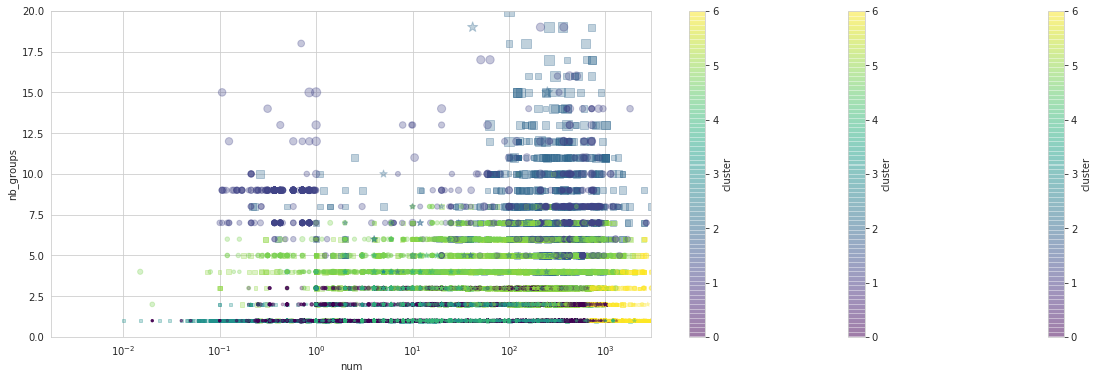

In [61]:
fig = plt.figure(figsize = (21, 6))
grid = plt.GridSpec(1, 1, wspace=0.2, hspace=0.1)
# grid = plt.GridSpec(1, 3, wspace=0.2, hspace=0.1)
np.warnings.filterwarnings('ignore')

mkr_dict = {'mass' : (1,'s'), 'volume' : (2,'o'), 'other' : (0,'*')}

ax1 = plt.subplot(grid[0, 0:1])
for mkr in mkr_dict:
  mask = df_quantity_f['q_unit_type'] == mkr_dict[mkr][0]
  log_num_max = 100*np.log(df_quantity_f[mask]['num'])
  df_quantity_f[mask].plot(ax = ax1, kind = 'scatter',
                           s = df_quantity_f[mask]['nb_char'],
                           y='nb_groups',x='num', c='cluster',
                           marker = mkr_dict[mkr][1], colormap='viridis',
                           xlim = (0,3000), ylim = (0,20), logx = True,
                           alpha=0.3, legend = False,) # figsize = (18,6))

# ax1 = plt.subplot(grid[0, 0:1])

# ax2 = plt.subplot(grid[0, 1:2])

# ax3 = plt.subplot(grid[0, 2:3])

# ax1.set_xlabel("number of groups (num-unit)")
# ax1.set_ylabel("total number of character")
# ax1.set_title("Features of 'quantity' data")

plt.show()

In [0]:
### Function giving description of data in a cluster
def analyses_cluster (df,n):
  df_cl = df[df['cluster']==n]
  print("o---- CLUSTER ", str(n), " ----o")
  print("nb rows", df_cl.shape[0])
  print("min and max num: ", df_cl['num'].min(), df_cl['num'].max())
  print("nb of empty unit: ", df_cl[(df_cl['unit']=='')].shape[0])
  print(df_cl['nb_groups'].value_counts())
 # print("----------- Data in the cluster with empty unit_max : --------")
 # return df_cl[(df_cl['unit_max']=='')]

In [63]:
# Checking the repartition of rows between clusters
for i in range(n_clust):
  print("cluster "+str(i)+" :",df_quantity_f[df_quantity_f['cluster']==i].shape)
# Then giving a summary of main characteristics
for i in range(n_clust):
  analyses_cluster(df_quantity_f,i)

cluster 0 : (82861, 13)
cluster 1 : (51790, 13)
cluster 2 : (1869, 13)
cluster 3 : (184251, 13)
cluster 4 : (5690, 13)
cluster 5 : (17518, 13)
cluster 6 : (7197, 13)
o---- CLUSTER  0  ----o
nb rows 82861
min and max num:  300.0 1300.0
nb of empty unit:  0
1    80081
2     2723
3       57
Name: nb_groups, dtype: int64
o---- CLUSTER  1  ----o
nb rows 51790
min and max num:  0.02 680.0
nb of empty unit:  0
1    49166
2     1934
3      675
4       15
Name: nb_groups, dtype: int64
o---- CLUSTER  2  ----o
nb rows 1869
min and max num:  0.1 3900.0
nb of empty unit:  0
7     391
8     354
9     341
6     233
10    133
5     129
11     94
12     54
13     29
4      27
14     22
15     17
16     11
17      7
19      6
18      4
23      4
21      3
22      2
26      2
31      2
27      1
20      1
24      1
25      1
Name: nb_groups, dtype: int64
o---- CLUSTER  3  ----o
nb rows 184251
min and max num:  0.01 385.0
nb of empty unit:  0
1    177843
2      5587
3       809
4        12
Name: nb_groups

In [64]:
# indexes of rows with empty 'unit'
idx_unit_na = df_quantity[df_quantity['unit'].isna()].index.to_list()
print("Found {} empty 'unit'.\n".format(len(idx_unit_na)))

# indexes of rows with 'num' 0, negative or values exceeding 6000
cond1 = df_quantity['num'].isna()
cond2 = df_quantity['num']>10000
cond3 = df_quantity['num']<=0
my_cond = (cond1|cond2|cond3)
idx_num_outl = df_quantity[my_cond].index.to_list()
print("Total {} outliers found in 'num'.".format(len(idx_num_outl)))
print("--> NaN: {0} - Outliers: {1} - Zero or negative: {2}"\
      .format(df_quantity[cond1].shape[0],
              df_quantity[cond2].shape[0],
              df_quantity[cond3].shape[0]))

Found 9343 empty 'unit'.

Total 10665 outliers found in 'num'.
--> NaN: 9343 - Outliers: 172 - Zero or negative: 1150


In [0]:
# Dropping rows where unit or num is invalid in df_quantity
df_quantity.drop(index=idx_unit_na+idx_num_outl, inplace=True)
# Setting value of 'quantity' in dfcopy also to NaN if unit or num is invalid 
dfcopy.loc[idx_unit_na+idx_num_outl, 'quantity'] = np.nan

In [66]:
# Merging df_quantity with dfcopy
print("dfcopy before: \n", dfcopy.shape,
      "\ndf_quantity: \n", df_quantity.shape)
dfcopy = dfcopy.merge(df_quantity[['num', 'unit','q_unit_type']],
                      how = 'left',  left_index=True, right_index=True)
dfcopy.rename(columns = {'num':'quantity_num',
                         'unit':'quantity_unit',
                          'q_unit_type':'quantity_type'},
                inplace=True)
# ---- NB : join on index works, whereas join on column 'quantity' doesn't.
cols = dfcopy.columns.to_list()
cols = cols[:9]+cols[-3:]+cols[9:-3]
dfcopy = dfcopy[cols]
print("---> dfcopy after: \n", dfcopy.shape)
dfcopy.head(3)

dfcopy before: 
 (1173417, 107) 
df_quantity: 
 (351185, 12)
---> dfcopy after: 
 (1173417, 110)


,code,code_val,url,creator,created_datetime,last_modified_datetime,product_name,generic_name,quantity,quantity_num,quantity_unit,quantity_type,packaging,brands,categories,categories_en,origins,manufacturing_places,labels,labels_en,emb_codes,first_packaging_code_geo,cities_tags,purchase_places,stores,countries,countries_en,ingredients_text,allergens,traces,traces_en,serving_size,serving_quantity,additives_n,additives_en,ingredients_from_palm_oil_n,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_tags,nutriscore_score,nutriscore_grade,nova_group,pnns_groups_1,pnns_groups_2,main_category,main_category_en,energy-kj_100g,energy-kcal_100g,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,-alpha-linolenic-acid_100g,omega-6-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,-lactose_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-dried_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr
0,0000000000017,True,http://world-en.openfoodfacts.org/product/0000...,kiliweb,2018-06-15T10:38:00Z,2019-06-25T11:55:18Z,Vitória crackers,NaN,NaN,nan,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,France,NaN,NaN,NaN,NaN,NaN,nan,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,unknown,unknown,NaN,NaN,nan,1569,1569,nan,7,3,nan,nan,nan,nan,nan,nan,nan,70,15,nan,nan,nan,nan,8,1,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,0000000000031,True,http://world-en.openfoodfacts.org/product/0000...,isagoofy,2018-10-13T21:06:14Z,2018-10-13T21:06:57Z,Cacao,NaN,130 g,130,g,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,France,NaN,NaN,NaN,NaN,NaN,nan,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,unknown,unknown,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,000000000003327986,False,http://world-en.openfoodfacts.org/product/0000...,kiliweb,2019-11-19T15:02:16Z,2019-11-19T15:02:17Z,Filetes de pollo empanado,NaN,NaN,nan,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:es,Spain,NaN,NaN,NaN,NaN,NaN,nan,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,unknown,unknown,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [67]:
# Checking rows with insufficient identification data
# Indexes of rows with invalid codes AND all key_cols NaN
m_wcode = dfcopy['code_val']==False
m_wkeys = dfcopy.loc[:,key_cols].isna().all(axis=1)

ind_drop = dfcopy[m_wcode&m_wkeys].index.to_list()

print("nb of rows with invalid code", m_wcode.sum())
print("nb of rows with all key-columns NaN:", m_wkeys.sum())
print("nb of rows with invalid code AND all key-columns NaN (to drop):", (m_wcode&m_wkeys).sum())

nb of rows with invalid code 21891
nb of rows with all key-columns NaN: 36690
nb of rows with invalid code AND all key-columns NaN (to drop): 1859


Data that have no key column filled have very few data anyway.
We drop all the 22183 rows.

In [68]:
# Dropping rows with invalid codes AND all key_cols NaN
print("nb of rows before:", dfcopy.shape[0])
dfcopy.drop(index=ind_drop, inplace=True)
print("nb of rows after:", dfcopy.shape[0])

nb of rows before: 1173417
nb of rows after: 1171558


* Condition 2:

Let's now check for the second condition that is "at least one numerical columns filled" among a selection of numerical data OR nutritional score

In [0]:
def nb_rows_allna (df, selcol):
  mask = dfcopy[selcol].isna().all(axis=1)
  ind_drop = dfcopy[mask].index.to_list()
  return len(ind_drop), ind_drop
  
def print_nb(df, selcol):
  print("------ columns: ", selcol, "\nnb of rows all NaN : ", nb_rows_allna(df, selcol)[0])

In [71]:
list(dfcopy.columns)

['code', 'code_val', 'url', 'creator', 'created_datetime', 'last_modified_datetime', 'product_name', 'generic_name', 'quantity', 'quantity_num', 'quantity_unit', 'quantity_type', 'packaging', 'brands', 'categories', 'categories_en', 'origins', 'manufacturing_places', 'labels', 'labels_en', 'emb_codes', 'first_packaging_code_geo', 'cities_tags', 'purchase_places', 'stores', 'countries', 'countries_en', 'ingredients_text', 'allergens', 'traces', 'traces_en', 'serving_size', 'serving_quantity', 'additives_n', 'additives_en', 'ingredients_from_palm_oil_n', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_tags', 'nutriscore_score', 'nutriscore_grade', 'nova_group', 'pnns_groups_1', 'pnns_groups_2', 'main_category', 'main_category_en', 'energy-kj_100g', 'energy-kcal_100g', 'energy_100g', 'energy-from-fat_100g', 'fat_100g', 'saturated-fat_100g', 'monounsaturated-fat_100g', 'polyunsaturated-fat_100g', 'omega-3-fat_100g', '-alph

In [75]:
# Display amount of rows to drop depending on selection of columns considered
cruc_num_col = ['energy_100g']
print_nb(dfcopy, cruc_num_col)
cruc_num_col += li_cat_comp
print_nb(dfcopy, cruc_num_col)
cruc_num_col += ['salt_100g']
print_nb(dfcopy, cruc_num_col)
cruc_num_col += li_cat_vit_oligo
print_nb(dfcopy, cruc_num_col)
cruc_num_col += li_cat_nutri
print_nb(dfcopy, cruc_num_col)

------ columns:  ['energy_100g'] 
nb of rows all NaN :  241841
------ columns:  ['energy_100g', 'fat_100g', 'carbohydrates_100g', 'proteins_100g'] 
nb of rows all NaN :  240303
------ columns:  ['energy_100g', 'fat_100g', 'carbohydrates_100g', 'proteins_100g', 'salt_100g'] 
nb of rows all NaN :  229883
------ columns:  ['energy_100g', 'fat_100g', 'carbohydrates_100g', 'proteins_100g', 'salt_100g', 'vitamin-e_100g', 'vitamin-k_100g', 'vitamin-c_100g', 'vitamin-b1_100g', 'vitamin-b2_100g', 'vitamin-pp_100g', 'vitamin-b6_100g', 'vitamin-b9_100g', 'folates_100g', 'vitamin-b12_100g', 'biotin_100g', 'pantothenic-acid_100g', 'silica_100g', 'bicarbonate_100g', 'potassium_100g', 'chloride_100g', 'calcium_100g', 'phosphorus_100g', 'iron_100g', 'magnesium_100g', 'zinc_100g', 'copper_100g', 'manganese_100g', 'fluoride_100g', 'selenium_100g', 'chromium_100g', 'molybdenum_100g', 'iodine_100g', 'caffeine_100g', 'taurine_100g', 'cocoa_100g'] 
nb of rows all NaN :  229619
------ columns:  ['energy_100g

We drop the 184 115 rows that do not have either one of the following 36 numerical '**XXX_100g**' columns:

['energy_100g'] + li_cat_comp + ['salt_100g'] + li_cat_vit_oligo

However, we keep the data with no nutritional data columns filled **li_cat_nutri**, as we are going to try to reconsruct those data later.

In [76]:
# Dropping rows with no numerical data filled among 'cruc_num_col' columns
cruc_num_col = ['energy_100g'] + li_cat_comp + ['salt_100g'] + li_cat_vit_oligo
print("nb of rows before:", dfcopy.shape[0])
print(nb_rows_allna(dfcopy, cruc_num_col)[0], "rows to drop")
dfcopy.drop(index=nb_rows_allna(dfcopy, cruc_num_col)[1], inplace=True)
print("nb of rows after:", dfcopy.shape[0])

nb of rows before: 1171558
229619 rows to drop
nb of rows after: 941939


In [77]:
speak('Dropped inoperable rows')

### Dealing with duplicates
At first we are going to deal with 'absolute' duplicates (i.e. duplicate on each row). We'll simply keep the first row.


In [78]:
# 1 - Checking for duplicates on all columns
df_dup_all = dfcopy[dfcopy.duplicated(keep=False)]
print("Nb of duplicated rows on all columns:", df_dup_all.shape[0])

Nb of duplicated rows on all columns: 30


In [79]:
# -> Keeping the first duplicated row
print("before", dfcopy.shape[0])
dfcopy = dfcopy[~dfcopy.duplicated(keep='first')]
print("after", dfcopy.shape[0])

before 941939
after 941924


Then, to deal with the duplicates on differents subsets of the columns (['code'] and key_cols), we are going to define a function that combines all the duplicated rows in one. The main row will be the one that has the greater number of unique not null values, and it will be unriched by date from the others rows if available (using pd.DataFrame.combine_first).

In [0]:
# Function combining all dupl. rows,
# '1st' is the one with highest unique notna val.
''' Among each group of duplicates :
 - finds nb of unique notna for each row
 - selects the one with the most unique notna
 - combines the rows (1st is the selected row)
 - replaces all the rows by combined row
 - returns nb of grps of dupl., indexes of rows to drop, list of rows for update
 '''
def comb_dup_rows(df, cols):
  uniq_notna = lambda x:pd.notna(x.unique()).sum()
  df_f = pd.DataFrame(columns = df.columns)
  l_ind = []
  cpt = 0
  for k,v in df.groupby(by=cols).groups.items(): # loop on all grps of dup.
    df_comb = pd.DataFrame({})
    ser_gr = df.loc[v].apply(uniq_notna, axis=1)
    idx_max = np.argmax(ser_gr)
    ind = list(ser_gr.index)
    ind.remove(idx_max)
    for i in ind: # loop on all dupl. except that with max unique not na
      df_comb = df.loc[idx_max:idx_max].reset_index()\
        .combine_first(df.loc[i:i].reset_index())\
        .set_index('index').rename_axis(None)\
        .drop(ind[1:], inplace = False).reindex(columns=df.columns)
    df_f = df_f.append(df_comb)
    l_ind += ind
    cpt += 1
  return cpt, l_ind, df_f 

Let's apply this function to dfcopy, with the subset ['code'] for the duplicates:

In [81]:
# 2 - Checking for duplicates on 'code'
df_dup = dfcopy[dfcopy.duplicated(subset=['code'],keep=False)]
print("Nb of duplicated rows on 'code':", df_dup.shape[0])

Nb of duplicated rows on 'code': 84


In [82]:
# duplicates on 'code' column
# -> Keeping the combined row, deleting the others
print("Shape of dfcopy, before", df_dup.shape[0])
nb_gr, ind_drop, df_dup_f = comb_dup_rows(df_dup, ['code'])
df_dup.drop(ind_drop, inplace=True)
df_dup.update(df_dup_f, overwrite=True)
print("Nb of groups of duplicates :", nb_gr)
print("Nb of duplicates :", df_dup.shape[0])
print("Nb of rows to delete:", len(ind_drop))
print("Shape of dfcopy, after", df_dup.shape[0])

Shape of dfcopy, before 84
Nb of groups of duplicates : 42
Nb of duplicates : 42
Nb of rows to delete: 42
Shape of dfcopy, after 42


In [0]:
# Changing dfcopy
dfcopy.drop(ind_drop, inplace=True)
dfcopy.update(df_dup_f, overwrite=True)

In [85]:
speak('dropping duplicates (on column code)')

29 duplicates has be deleted, and 29 rows updated.

Let's apply this function to dfcopy, with the subset key_cols for the duplicates:

In [88]:
# 3 - Checking for duplicates on key_cols with invalid code
key_cols = ['product_name', 'quantity_num', 'quantity_unit', 'brands']
cond_1 = dfcopy.duplicated(subset=key_cols,keep=False)
cond_2 = dfcopy['code_val']==False
df_dup = dfcopy[cond_1 & cond_2]
print("Nb of duplicated rows on key_cols with invalid code:", df_dup.shape[0])

Nb of duplicated rows on key_cols with invalid code: 4330


In [0]:
# si dans les dupliqués l'un des deux a un code valide, garder le valide

In [89]:
df_dup = df_dup.sort_values('product_name').head(7)
df_dup

,code,code_val,url,creator,created_datetime,last_modified_datetime,product_name,generic_name,quantity,quantity_num,quantity_unit,quantity_type,packaging,brands,categories,categories_en,origins,manufacturing_places,labels,labels_en,emb_codes,first_packaging_code_geo,cities_tags,purchase_places,stores,countries,countries_en,ingredients_text,allergens,traces,traces_en,serving_size,serving_quantity,additives_n,additives_en,ingredients_from_palm_oil_n,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_tags,nutriscore_score,nutriscore_grade,nova_group,pnns_groups_1,pnns_groups_2,main_category,main_category_en,energy-kj_100g,energy-kcal_100g,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,-alpha-linolenic-acid_100g,omega-6-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,-lactose_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-dried_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr
41005,00358626807719001458,False,http://world-en.openfoodfacts.org/product/0035...,kiliweb,2019-09-29T08:28:06Z,2020-01-10T14:20:24Z,&quot;Trinxat&quot; de col y patata con panceta,NaN,NaN,nan,NaN,nan,NaN,Bonarea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:es,Spain,NaN,NaN,NaN,NaN,NaN,nan,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,unknown,unknown,NaN,NaN,nan,674,674,nan,10,2,nan,nan,nan,nan,nan,nan,nan,13,0,nan,nan,nan,nan,4,1,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
40992,00358600909820001425,False,http://world-en.openfoodfacts.org/product/0035...,kiliweb,2020-01-18T12:39:25Z,2020-01-23T10:35:51Z,&quot;Trinxat&quot; de col y patata con panceta,NaN,NaN,nan,NaN,nan,NaN,Bonarea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:es,Spain,NaN,NaN,NaN,NaN,NaN,nan,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,unknown,unknown,NaN,NaN,nan,674,674,nan,10,2,nan,nan,nan,nan,nan,nan,nan,13,0,nan,nan,nan,nan,4,1,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
202350,07004410097,False,http://world-en.openfoodfacts.org/product/0700...,usda-ndb-import,2017-03-09T16:59:39Z,2019-07-10T07:59:02Z,100% Natural Raisins,NaN,NaN,nan,NaN,nan,NaN,Clover Valley,"Plant-based foods and beverages, Plant-based f...","Plant-based foods and beverages,Plant-based fo...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,United States,United States,Raisins.,NaN,NaN,NaN,28 g (1 BOX),28,0,NaN,0,NaN,0,NaN,4,c,1,Fruits and vegetables,Dried fruits,en:plant-based-foods-and-beverages,Plant-based foods and beverages,nan,1343,1343,nan,0,0,0,0,nan,nan,nan,0,0,79,61,nan,nan,nan,4,4,0,0,nan,0,nan,nan,nan,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,nan,0,nan,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,4
266534,16300168357,False,http://world-en.openfoodfacts.org/product/1630...,kiliweb,2019-07-31T11:22:03Z,2019-07-31T11:22:03Z,100% Premium Orange Juice Most Pulp,NaN,NaN,nan,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:my,Malaysia,NaN,NaN,NaN,NaN,NaN,nan,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,unknown,unknown,NaN

In [0]:
# duplicates on key_cols column
# -> Keeping the combined row, deleting the others
# print("Shape of dfcopy, before", df_dup.shape[0])
# nb_gr, ind_drop, df_dup_f = comb_dup_rows(df_dup, key_cols)
# df_dup.drop(ind_drop, inplace=True)
# df_dup.update(df_dup_f, overwrite=True)
# print("Nb of groups of duplicates :", nb_gr)
# print("Nb of duplicates :", df_dup.shape[0])
# print("Nb of rows to delete:", len(ind_drop))
# print("Shape of dfcopy, after", df_dup.shape[0])
# comb_dup_rows(df_dup, key_cols)